### Cybersecurity Risk Modeling Script using PYFAIR and Loss Distribution Approach

**Description: Comprehensive risk quantification using multiple approaches**

* Built using pyfair library and claude.ai


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import lognorm, gamma, beta
import warnings
warnings.filterwarnings('ignore')
import pyfair
from pyfair import FairModel
from pyfair.report import simple_report

# Install required packages:
# pip install pyfair numpy pandas matplotlib seaborn scipy

# try:
#     import pyfair
#     from pyfair import FairModel
#     from pyfair.report import FairReport
#     PYFAIR_AVAILABLE = True
# except ImportError:
#     print("Warning: pyfair not installed. Install with: pip install pyfair")
#     PYFAIR_AVAILABLE = False

In [11]:
class CyberRiskModel:
    """
    Comprehensive cybersecurity risk modeling class combining multiple approaches
    """
    
    def __init__(self):
        self.scenarios = {}
        self.results = {}
        
    def create_fair_model(self, scenario_name, params):
        """
        Create a FAIR (Factor Analysis of Information Risk) model
        """
        if not PYFAIR_AVAILABLE:
            print("PYFAIR library not available. Using alternative approach.")
            return self._alternative_fair_model(scenario_name, params)
        
        # Create FAIR model
        model = FairModel(name=scenario_name, n_simulations=10000)
        
        # Set Loss Event Frequency (LEF) parameters
        model.input_data('Loss Event Frequency', 
                        low=params['lef_low'], 
                        mode=params['lef_mode'], 
                        high=params['lef_high'])
        
        # Set Primary Loss Magnitude (PLM) parameters
        model.input_data('Primary Loss Magnitude', 
                        low=params['plm_low'], 
                        mode=params['plm_mode'], 
                        high=params['plm_high'])
        
        # Set Secondary Loss Magnitude (SLM) parameters if provided
        if 'slm_low' in params:
            model.input_data('Secondary Loss Magnitude', 
                            low=params['slm_low'], 
                            mode=params['slm_mode'], 
                            high=params['slm_high'])
        
        # Calculate risk
        model.calculate_all()
        
        # Store model
        self.scenarios[scenario_name] = model
        
        return model
    
    def _alternative_fair_model(self, scenario_name, params):
        """
        Alternative FAIR model implementation using basic Monte Carlo
        """
        n_simulations = 10000
        
        # Generate Loss Event Frequency using PERT distribution
        lef_samples = self._pert_distribution(params['lef_low'], 
                                            params['lef_mode'], 
                                            params['lef_high'], 
                                            n_simulations)
        
        # Generate Primary Loss Magnitude using PERT distribution
        plm_samples = self._pert_distribution(params['plm_low'], 
                                            params['plm_mode'], 
                                            params['plm_high'], 
                                            n_simulations)
        
        # Generate Secondary Loss Magnitude if provided
        if 'slm_low' in params:
            slm_samples = self._pert_distribution(params['slm_low'], 
                                                params['slm_mode'], 
                                                params['slm_high'], 
                                                n_simulations)
        else:
            slm_samples = np.zeros(n_simulations)
        
        # Calculate Annual Loss Expectancy (ALE)
        ale_samples = lef_samples * (plm_samples + slm_samples)
        
        # Create results dictionary
        results = {
            'name': scenario_name,
            'ale_samples': ale_samples,
            'lef_samples': lef_samples,
            'plm_samples': plm_samples,
            'slm_samples': slm_samples,
            'statistics': {
                'mean': np.mean(ale_samples),
                'median': np.median(ale_samples),
                'std': np.std(ale_samples),
                'var': np.var(ale_samples),
                'min': np.min(ale_samples),
                'max': np.max(ale_samples),
                'percentiles': {
                    '5%': np.percentile(ale_samples, 5),
                    '10%': np.percentile(ale_samples, 10),
                    '25%': np.percentile(ale_samples, 25),
                    '75%': np.percentile(ale_samples, 75),
                    '90%': np.percentile(ale_samples, 90),
                    '95%': np.percentile(ale_samples, 95),
                    '99%': np.percentile(ale_samples, 99)
                }
            }
        }
        
        self.scenarios[scenario_name] = results
        return results
    
    def _pert_distribution(self, low, mode, high, size):
        """
        Generate samples from PERT distribution (modified Beta distribution)
        """
        # PERT distribution parameters
        alpha = 1 + 4 * (mode - low) / (high - low)
        beta_param = 1 + 4 * (high - mode) / (high - low)
        
        # Generate beta samples and scale to range
        beta_samples = beta.rvs(alpha, beta_param, size=size)
        return low + beta_samples * (high - low)
    
    def loss_distribution_analysis(self, scenario_name, loss_data=None):
        """
        Advanced loss distribution analysis using multiple probability distributions
        """
        if loss_data is None:
            # Use scenario data if available
            if scenario_name in self.scenarios:
                if isinstance(self.scenarios[scenario_name], dict):
                    loss_data = self.scenarios[scenario_name]['ale_samples']
                else:
                    # For PYFAIR models, extract results
                    loss_data = self.scenarios[scenario_name].results_df()['Risk']
            else:
                raise ValueError(f"No data available for scenario: {scenario_name}")
        
        # Fit multiple distributions
        distributions = {
            'lognormal': stats.lognorm,
            'gamma': stats.gamma,
            'exponential': stats.expon,
            'weibull': stats.weibull_min
        }
        
        fitted_distributions = {}
        
        for dist_name, distribution in distributions.items():
            try:
                # Fit distribution
                params = distribution.fit(loss_data)
                fitted_distributions[dist_name] = {
                    'distribution': distribution,
                    'params': params,
                    'aic': self._calculate_aic(loss_data, distribution, params),
                    'bic': self._calculate_bic(loss_data, distribution, params)
                }
            except Exception as e:
                print(f"Failed to fit {dist_name}: {e}")
        
        # Find best fitting distribution
        best_dist = min(fitted_distributions.keys(), 
                       key=lambda x: fitted_distributions[x]['aic'])
        
        # Calculate VaR and CVaR
        var_95 = np.percentile(loss_data, 95)
        var_99 = np.percentile(loss_data, 99)
        cvar_95 = np.mean(loss_data[loss_data >= var_95])
        cvar_99 = np.mean(loss_data[loss_data >= var_99])
        
        results = {
            'scenario': scenario_name,
            'fitted_distributions': fitted_distributions,
            'best_distribution': best_dist,
            'var_95': var_95,
            'var_99': var_99,
            'cvar_95': cvar_95,
            'cvar_99': cvar_99,
            'loss_data': loss_data
        }
        
        self.results[f"{scenario_name}_lda"] = results
        return results
    
    def _calculate_aic(self, data, distribution, params):
        """Calculate Akaike Information Criterion"""
        log_likelihood = np.sum(distribution.logpdf(data, *params))
        return 2 * len(params) - 2 * log_likelihood
    
    def _calculate_bic(self, data, distribution, params):
        """Calculate Bayesian Information Criterion"""
        log_likelihood = np.sum(distribution.logpdf(data, *params))
        return len(params) * np.log(len(data)) - 2 * log_likelihood
    
    def bow_tie_analysis(self, scenario_name, threat_freq, vulnerability_prob, 
                        impact_low, impact_high, control_effectiveness=0.8):
        """
        Bow-tie analysis for risk assessment
        """
        n_simulations = 10000
        
        # Generate threat events
        threat_events = np.random.poisson(threat_freq, n_simulations)
        
        # Apply vulnerability probability
        successful_attacks = np.random.binomial(threat_events, vulnerability_prob)
        
        # Apply control effectiveness
        unmitigated_attacks = np.random.binomial(successful_attacks, 1 - control_effectiveness)
        
        # Generate impact values
        impacts = np.random.uniform(impact_low, impact_high, n_simulations)
        
        # Calculate losses
        losses = unmitigated_attacks * impacts
        
        results = {
            'scenario': scenario_name,
            'losses': losses,
            'threat_events': threat_events,
            'successful_attacks': successful_attacks,
            'unmitigated_attacks': unmitigated_attacks,
            'statistics': {
                'mean_loss': np.mean(losses),
                'median_loss': np.median(losses),
                'var_95': np.percentile(losses, 95),
                'var_99': np.percentile(losses, 99),
                'max_loss': np.max(losses)
            }
        }
        
        self.results[f"{scenario_name}_bowtie"] = results
        return results
    
    def generate_risk_report(self, scenario_name):
        """
        Generate comprehensive risk report
        """
        print(f"\n{'='*60}")
        print(f"CYBERSECURITY RISK ASSESSMENT REPORT")
        print(f"Scenario: {scenario_name}")
        print(f"{'='*60}")
        
        # FAIR Model Results
        if scenario_name in self.scenarios:
            scenario = self.scenarios[scenario_name]
            if isinstance(scenario, dict):
                stats = scenario['statistics']
                print(f"\nFAIR MODEL RESULTS:")
                print(f"Annual Loss Expectancy (ALE):")
                print(f"  Mean: ${stats['mean']:,.2f}")
                print(f"  Median: ${stats['median']:,.2f}")
                print(f"  Standard Deviation: ${stats['std']:,.2f}")
                print(f"  5th Percentile: ${stats['percentiles']['5%']:,.2f}")
                print(f"  95th Percentile: ${stats['percentiles']['95%']:,.2f}")
                print(f"  99th Percentile: ${stats['percentiles']['99%']:,.2f}")
        
        # Loss Distribution Analysis Results
        lda_key = f"{scenario_name}_lda"
        if lda_key in self.results:
            lda = self.results[lda_key]
            print(f"\nLOSS DISTRIBUTION ANALYSIS:")
            print(f"  Best Fitting Distribution: {lda['best_distribution']}")
            print(f"  Value at Risk (95%): ${lda['var_95']:,.2f}")
            print(f"  Value at Risk (99%): ${lda['var_99']:,.2f}")
            print(f"  Conditional VaR (95%): ${lda['cvar_95']:,.2f}")
            print(f"  Conditional VaR (99%): ${lda['cvar_99']:,.2f}")
        
        # Bow-tie Analysis Results
        bowtie_key = f"{scenario_name}_bowtie"
        if bowtie_key in self.results:
            bowtie = self.results[bowtie_key]
            print(f"\nBOW-TIE ANALYSIS:")
            print(f"  Mean Annual Loss: ${bowtie['statistics']['mean_loss']:,.2f}")
            print(f"  Median Annual Loss: ${bowtie['statistics']['median_loss']:,.2f}")
            print(f"  95% VaR: ${bowtie['statistics']['var_95']:,.2f}")
            print(f"  99% VaR: ${bowtie['statistics']['var_99']:,.2f}")
            print(f"  Maximum Potential Loss: ${bowtie['statistics']['max_loss']:,.2f}")
    
    def visualize_results(self, scenario_name, save_plots=False):
        """
        Create comprehensive visualizations
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Cybersecurity Risk Analysis: {scenario_name}', fontsize=16)
        
        # Plot 1: ALE Distribution
        if scenario_name in self.scenarios:
            scenario = self.scenarios[scenario_name]
            if isinstance(scenario, dict):
                ale_data = scenario['ale_samples']
                axes[0, 0].hist(ale_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                axes[0, 0].set_title('Annual Loss Expectancy Distribution')
                axes[0, 0].set_xlabel('Loss Amount ($)')
                axes[0, 0].set_ylabel('Frequency')
                axes[0, 0].axvline(np.mean(ale_data), color='red', linestyle='--', label='Mean')
                axes[0, 0].axvline(np.percentile(ale_data, 95), color='orange', linestyle='--', label='95% VaR')
                axes[0, 0].legend()
        
        # Plot 2: Loss Distribution Analysis
        lda_key = f"{scenario_name}_lda"
        if lda_key in self.results:
            lda = self.results[lda_key]
            loss_data = lda['loss_data']
            
            # Plot histogram with fitted distribution
            axes[0, 1].hist(loss_data, bins=50, alpha=0.7, density=True, color='lightgreen')
            
            # Plot best fit distribution
            best_dist_name = lda['best_distribution']
            best_dist = lda['fitted_distributions'][best_dist_name]
            x = np.linspace(np.min(loss_data), np.max(loss_data), 1000)
            y = best_dist['distribution'].pdf(x, *best_dist['params'])
            axes[0, 1].plot(x, y, 'r-', linewidth=2, label=f'Best Fit: {best_dist_name}')
            axes[0, 1].set_title('Loss Distribution Analysis')
            axes[0, 1].set_xlabel('Loss Amount ($)')
            axes[0, 1].set_ylabel('Probability Density')
            axes[0, 1].legend()
        
        # Plot 3: Risk Metrics Comparison
        metrics = {}
        if scenario_name in self.scenarios:
            scenario = self.scenarios[scenario_name]
            if isinstance(scenario, dict):
                stats = scenario['statistics']
                metrics['FAIR Mean'] = stats['mean']
                metrics['FAIR 95% VaR'] = stats['percentiles']['95%']
        
        if lda_key in self.results:
            lda = self.results[lda_key]
            metrics['LDA 95% VaR'] = lda['var_95']
            metrics['LDA 99% VaR'] = lda['var_99']
        
        bowtie_key = f"{scenario_name}_bowtie"
        if bowtie_key in self.results:
            bowtie = self.results[bowtie_key]
            metrics['Bow-tie Mean'] = bowtie['statistics']['mean_loss']
            metrics['Bow-tie 95% VaR'] = bowtie['statistics']['var_95']
        
        if metrics:
            metric_names = list(metrics.keys())
            metric_values = list(metrics.values())
            axes[1, 0].bar(metric_names, metric_values, color=['blue', 'green', 'red', 'orange', 'purple', 'brown'])
            axes[1, 0].set_title('Risk Metrics Comparison')
            axes[1, 0].set_ylabel('Loss Amount ($)')
            axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Plot 4: Percentile Analysis
        if scenario_name in self.scenarios:
            scenario = self.scenarios[scenario_name]
            if isinstance(scenario, dict):
                ale_data = scenario['ale_samples']
                percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
                values = [np.percentile(ale_data, p) for p in percentiles]
                axes[1, 1].plot(percentiles, values, 'o-', linewidth=2, markersize=8)
                axes[1, 1].set_title('Risk Percentile Analysis')
                axes[1, 1].set_xlabel('Percentile')
                axes[1, 1].set_ylabel('Loss Amount ($)')
                axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'risk_analysis_{scenario_name}.png', dpi=300, bbox_inches='tight')
        
        plt.show()


Analyzing Data Breach Scenario...
PYFAIR library not available. Using alternative approach.

CYBERSECURITY RISK ASSESSMENT REPORT
Scenario: data_breach

FAIR MODEL RESULTS:
Annual Loss Expectancy (ALE):
  Mean: $289,461.74
  Median: $243,892.76
  Standard Deviation: $191,638.00
  5th Percentile: $69,448.64
  95th Percentile: $661,059.34
  99th Percentile: $903,836.63

LOSS DISTRIBUTION ANALYSIS:
  Best Fitting Distribution: gamma
  Value at Risk (95%): $661,059.34
  Value at Risk (99%): $903,836.63
  Conditional VaR (95%): $816,507.59
  Conditional VaR (99%): $1,042,230.47

BOW-TIE ANALYSIS:
  Mean Annual Loss: $45,175.30
  Median Annual Loss: $0.00
  95% VaR: $360,702.21
  99% VaR: $496,997.26
  Maximum Potential Loss: $1,404,440.46


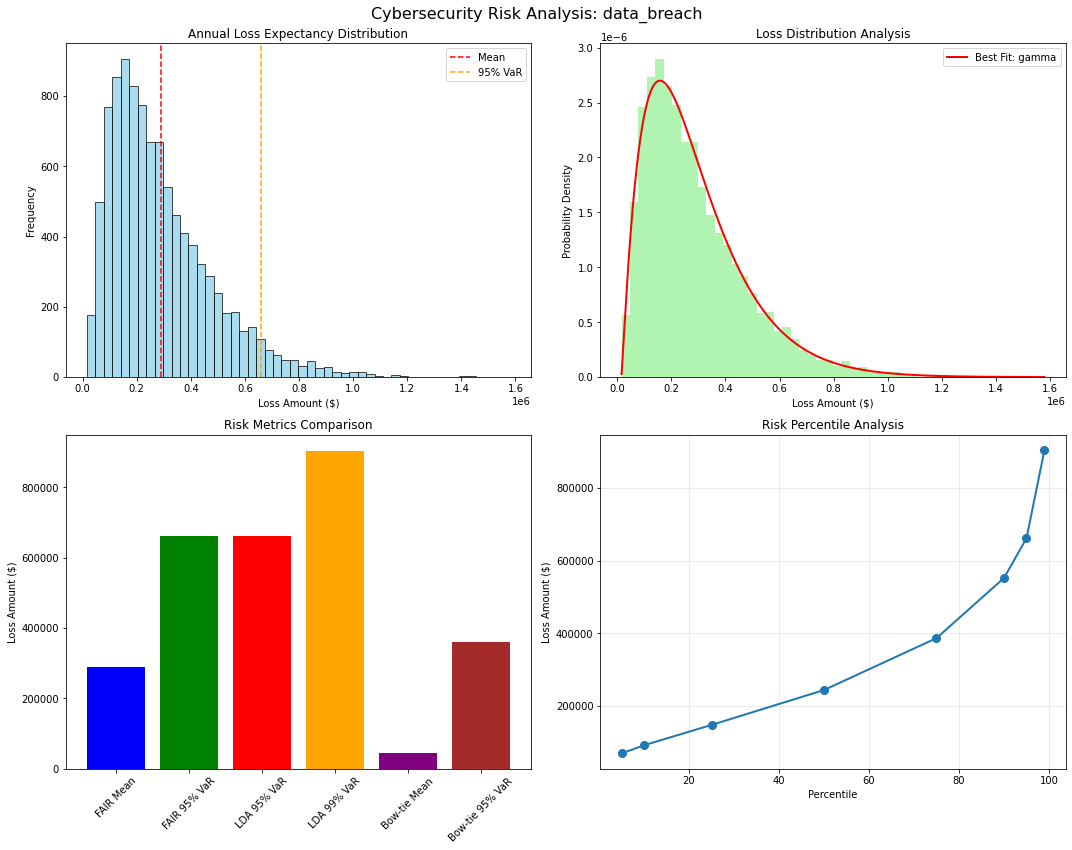


Analyzing Ransomware Attack Scenario...
PYFAIR library not available. Using alternative approach.

CYBERSECURITY RISK ASSESSMENT REPORT
Scenario: ransomware

FAIR MODEL RESULTS:
Annual Loss Expectancy (ALE):
  Mean: $1,185,180.30
  Median: $1,051,546.37
  Standard Deviation: $684,826.76
  5th Percentile: $337,119.64
  95th Percentile: $2,507,138.16
  99th Percentile: $3,346,974.88

LOSS DISTRIBUTION ANALYSIS:
  Best Fitting Distribution: gamma
  Value at Risk (95%): $2,507,138.16
  Value at Risk (99%): $3,346,974.88
  Conditional VaR (95%): $3,001,319.27
  Conditional VaR (99%): $3,767,580.79

BOW-TIE ANALYSIS:
  Mean Annual Loss: $126,722.12
  Median Annual Loss: $0.00
  95% VaR: $824,285.89
  99% VaR: $1,347,749.96
  Maximum Potential Loss: $2,995,146.95


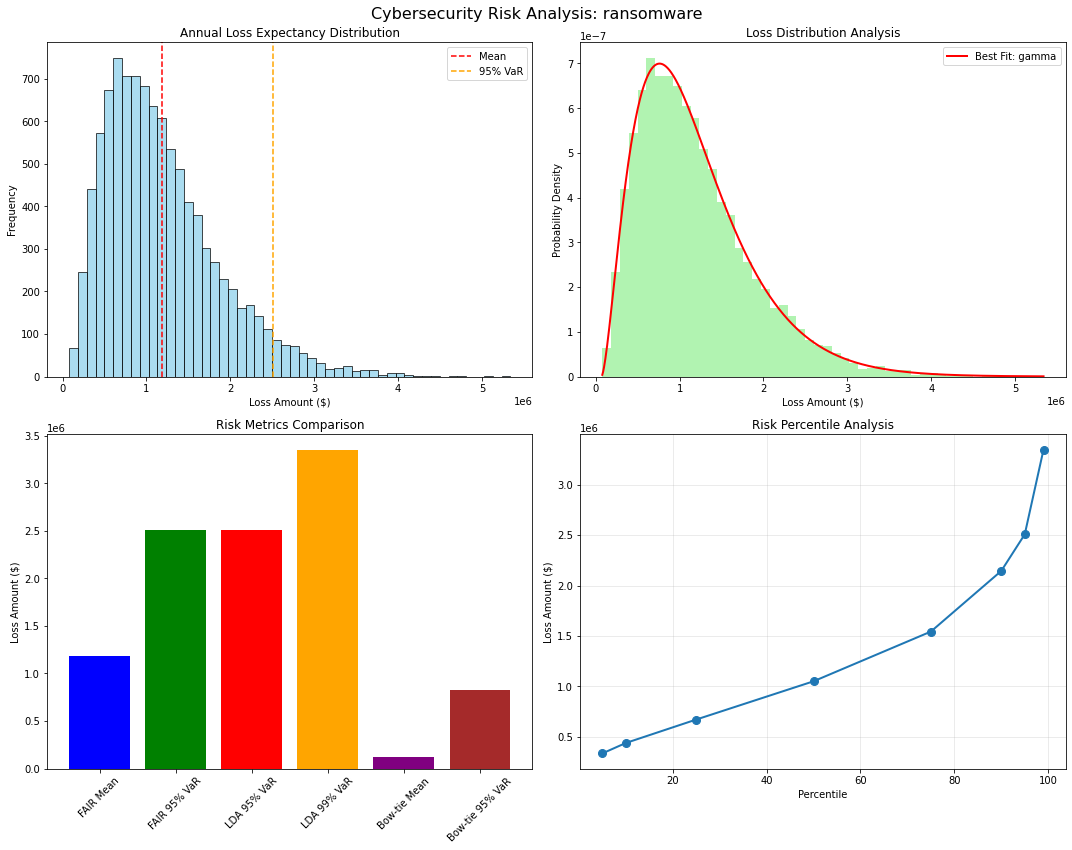


Risk analysis complete! Check the generated plots and reports.


In [12]:
def main():
    """
    Main execution function with example scenarios
    """
    # Initialize risk model
    risk_model = CyberRiskModel()
    
    # Example Scenario 1: Data Breach
    print("Analyzing Data Breach Scenario...")
    data_breach_params = {
        'lef_low': 0.1,      # Low estimate of loss events per year
        'lef_mode': 0.5,     # Most likely estimate
        'lef_high': 2.0,     # High estimate
        'plm_low': 50000,    # Primary loss magnitude (low)
        'plm_mode': 200000,  # Primary loss magnitude (mode)
        'plm_high': 1000000, # Primary loss magnitude (high)
        'slm_low': 10000,    # Secondary loss magnitude (low)
        'slm_mode': 50000,   # Secondary loss magnitude (mode)
        'slm_high': 500000   # Secondary loss magnitude (high)
    }
    
    # Create FAIR model
    risk_model.create_fair_model('data_breach', data_breach_params)
    
    # Perform loss distribution analysis
    risk_model.loss_distribution_analysis('data_breach')
    
    # Perform bow-tie analysis
    risk_model.bow_tie_analysis('data_breach', 
                               threat_freq=2.0,      # 2 threats per year
                               vulnerability_prob=0.3, # 30% chance of successful exploit
                               impact_low=10000,      # Minimum impact
                               impact_high=500000,    # Maximum impact
                               control_effectiveness=0.7) # 70% control effectiveness
    
    # Generate comprehensive report
    risk_model.generate_risk_report('data_breach')
    
    # Create visualizations
    risk_model.visualize_results('data_breach', save_plots=True)
    
    # Example Scenario 2: Ransomware Attack
    print("\nAnalyzing Ransomware Attack Scenario...")
    ransomware_params = {
        'lef_low': 0.2,
        'lef_mode': 1.0,
        'lef_high': 3.0,
        'plm_low': 100000,
        'plm_mode': 500000,
        'plm_high': 2000000,
        'slm_low': 50000,
        'slm_mode': 200000,
        'slm_high': 1000000
    }
    
    risk_model.create_fair_model('ransomware', ransomware_params)
    risk_model.loss_distribution_analysis('ransomware')
    risk_model.bow_tie_analysis('ransomware', 
                               threat_freq=1.5,
                               vulnerability_prob=0.4,
                               impact_low=50000,
                               impact_high=1000000,
                               control_effectiveness=0.6)
    
    risk_model.generate_risk_report('ransomware')
    risk_model.visualize_results('ransomware', save_plots=True)
    
    print("\nRisk analysis complete! Check the generated plots and reports.")

if __name__ == "__main__":
    main()